# Projet final du Kit Big Data 2022

---

Le projet final du Kit Big Data 2022 porte sur les données du **Vendée Globe 2020-2021**.

Le projet se déroule **24 novembre au 4 décembre 2022** date limite pour rendre vos projets respectifs.

Les données du dernier **Vendée Globe** sont disponibles sous la forme de fichiers Excel avec les classements fournis plusieurs fois par jour par les organisateurs de la course. Il y a également une page web avec une fiche technique par voilier qui contient des informations techniques et qu'il est possible de rapprocher des classements.

Il vous appartient de charger les données en Python, de procéder aux préparations nécessaires et d'effectuer les analyses pertinentes de votre choix.

Le rendu sera un notebook Jupyter fourni aux formats ipynb et HTML.

**Barème sur 15 points** :

* Acquisition et chargement des données : 3 points
* Préparation des données : 5 points
* Analyses et story telling : 7 points


In [120]:
# Imports
import pandas as pd
import os
import numpy as np
import string

from shutil import copyfileobj, move
from urllib import request
from urllib.error import HTTPError

import pickle
import warnings
from collections import defaultdict

import requests
from bs4 import BeautifulSoup
import dateparser

from datetime import timedelta
from scipy.stats import pearsonr, mannwhitneyu

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import ipywidgets
import plotly.graph_objects as go
import plotly.express as px

# les excels sont mal formattés, même le workaround ne fonctionne pas chez moi (erreurs diverses)
# sur mes différents environnement de dev (env local conda sur Ubuntu, google colab, env conda sur shadow Windows)

# solution 1
import pylightxl as xl # en voilà une librairie correctement testée ...
# solution 2
import xlrd # version 1.2.0 maximum, après les problèmes commencent

In [3]:
# Constantes

chemin_data = "./data"

types_tableaux = ['course', 'arrivee']

columns_course = ['rang', 'nationalite', 'skipper', 'heure', 'latitude', 'longitude', 'cap_30min', 'vitesse_30min', 'vmg_30min', 'dist_30min', 'cap_prec', 'vitesse_prec', 'vmg_prec', 'dist_prec', 'cap_24h', 'vitesse_24h', 'vmg_24h', 'dist_24h', 'dtf', 'dtl'] # prec pour précédent classement
columns_arrivee = ['rang', 'nationalite', 'skipper', 'date_arrivee', 'temps_course', 'ecart_premier', 'ecart_precedent', 'vitesse_ortho', 'distance_ortho', 'pourcentage', 'vitesse', 'distance']
columns = [columns_course, columns_arrivee]

indic_debut_tableau = "Rang\nRank"
indic_debut_tableau_course = "Heure FR\nHour FR"
indic_debut_tableau_arrivee = "Date d'arrivée\nArrival date"
indic_fin_fichier = "Traitements et calculs"

columns_course_indices_xl = ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U']
columns_arrivee_indices_xl = ['B', 'C', 'D', 'H', 'I', 'N', 'P', 'Q', 'R', 'S', 'T', 'U']
columns_indices_xl = [columns_course_indices_xl, columns_arrivee_indices_xl]

decalage_entete = 2

format_date = '%Y%m%d_%H%M%S'

---
---

# I) Acquisition et chargement des données

---

## I.1) Acquérir l'ensemble des fichiers Excel des classements via la page de classement. Mettre en place une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.

In [4]:
# Fonction pour collecter les fichiers du site du Vendée Globe
# Les télécharge uniquement, sans les traiter, leur contenu étant encore partiellement inconnu
def collecte_fichiers_vendeeglobe():
    dates_fichiers_effectives = list()
    dates_fichiers = pd.date_range('2020-11-08 ', '2021-03-06', freq='1H').strftime(format_date).to_series().to_list()
    dates_fichiers.append('')
    for date in dates_fichiers:
        fichier = f'vendeeglobe_{date}.xlsx'
        url = f'https://www.vendeeglobe.org/download-race-data/{fichier}'
        try :
            # tente de récupérer le fichier
            reponse = request.urlopen(url)
            # ecrit son contenu dans un fichier en local 
            with open(fichier, 'wb') as fichier_sortie:
                copyfileobj(reponse, fichier_sortie)
            # deplace le fichier local dans le dossier data
            move(fichier, os.path.join('.','data', f'vendeeglobe_{date}.xlsx'))
            # enregistre la date
            dates_fichiers_effectives.append(date)
        except HTTPError: # Passe au prochain fichier si aucun à récupérer (Erreur HTTP 404)
            pass
    return dates_fichiers_effectives

In [5]:
#dates_fichiers_effectives = collecte_fichiers_vendeeglobe()

In [6]:
#with open('dates_fichiers_effectives.pickle', 'wb') as handle:
    #pickle.dump(dates_fichiers_effectives, handle)

In [7]:
with open('dates_fichiers_effectives.pickle', 'rb') as pickle_file:
    dates_fichiers_effectives = pickle.load(pickle_file)

In [8]:
# charge un fichier de données et le transforme en DataFrame
# après analyse manuelle de fichiers
# les colonnes sont indiquées en dur
# renvoie un dictionnaire de DataFrame pandas
def charge(chemin_fichier, 
           date_fichier):
    
    # prepare le resultat
    df_dict = dict()
    
    # vérifie que le nombre de colonnes est correct
    if len(columns) != len(columns_indices_xl):
        print("Problème, le nombre de colonnes ne correspond pas au nombre d'indice passé en argument")
    
    # ignore les warnings de pylightxl concernant les fichier excel qui sont mal formattés
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        db = xl.readxl(chemin_fichier, ws='fr')
    
    # extrait les données
    df = pd.DataFrame([r for r in db.ws(ws='fr').rows])
    # ayant constaté la structure des fichiers
    # il y a au maximum 2 tableaux par fichier, empilés verticalement
    # le tableau du bas est toujours celui des skippers en course
    # le tableau au-dessus est celui des skippers arrivés
    # s'il n'y a qu'un tableau, son en-tête l'identifie
    # chaque tableau commence avec la même ligne de 'rang'
    # les données commencent 2 lignes après la ligne de 'rang'
    # par ailleurs, la colonne 'A' est vide
    mask_dfs = (df.iloc[:,1] == indic_debut_tableau).cumsum()
    mask_fin = 1 - df.iloc[:,1].str.startswith(indic_fin_fichier).cumsum()
    mask_dfs_delim = mask_dfs * mask_fin
    
    # id de tableau
    id_dfs = np.unique(mask_dfs).tolist()[1:]
    # parcourt les id de tableau
    for id_df in id_dfs:
        # restreint à la zone du tableau identifié
        dfi = df[mask_dfs_delim == id_df]
        # identifie le type du tableau, course ou arrivée
        id_type_tableau = 1 if dfi.iloc[0, 4] == indic_debut_tableau_arrivee else 0
        # sélectionne les colonnes en fonction du type
        columns_indices = [i for i, lettre in enumerate(string.ascii_uppercase) if lettre in columns_indices_xl[id_type_tableau]]
        dfi = dfi.iloc[2:, columns_indices]
        dfi.columns = columns[id_type_tableau]
        dfi['date_fichier'] = date_fichier
        dfi.reset_index(drop = True, inplace = True)
        df_dict[types_tableaux[id_type_tableau]] = dfi
        
    return df_dict

In [9]:
# teste la fonction avec un fichier ayant les 2 tableaux
test_charge_2_tab = charge(os.path.join(".", "data", 'vendeeglobe_20210128_170000.xlsx'), '20210128_170000')
test_charge_2_tab['arrivee'].head(3)

,rang,nationalite,skipper,date_arrivee,temps_course,ecart_premier,ecart_precedent,vitesse_ortho,distance_ortho,pourcentage,vitesse,distance,date_fichier
0,1\nARV,\nFRA 17,Yannick Bestaven\nMaître Coq IV,28/01/2021 05:19:46 FR,80j 03h 44min 46s\n-10h 15min 00s,,,12.6 kts,24365.7 nm,117.3 %,14.8 kts,28583.8 nm,20210128_170000
1,2\nARV,\nFRA 79,Charlie Dalin\nAPIVIA,27/01/2021 21:35:47 FR,80j 06h 15min 47s\n,02h 31min 01s,02h 31min 01s,12.6 kts,24365.7 nm,119.6 %,15.1 kts,29135.0 nm,20210128_170000
2,3\nARV,\nFRA 18,Louis Burton\nBureau Vallée 2,28/01/2021 01:45:12 FR,80j 10h 25min 12s\n,06h 40min 26s,04h 09min 25s,12.6 kts,24365.7 nm,117.6 %,14.8 kts,28650.0 nm,20210128_170000


In [10]:
# teste la fonction avec un fichier ayant uniquement le tableau de course
test_charge_1_tab_course = charge(os.path.join(".", "data", 'vendeeglobe_20210305_080000.xlsx'), '20210305_080000')
test_charge_1_tab_course['arrivee'].head(3)

,rang,nationalite,skipper,date_arrivee,temps_course,ecart_premier,ecart_precedent,vitesse_ortho,distance_ortho,pourcentage,vitesse,distance,date_fichier
0,1\nARV,\nFRA 17,Yannick Bestaven\nMaître Coq IV,28/01/2021 04:19:46 FR,80j 03h 44min 46s\n-10h 15min 00s,,,12.6 kts,24365.7 nm,117.3 %,14.8 kts,28583.8 nm,20210305_080000
1,2\nARV,\nFRA 79,Charlie Dalin\nAPIVIA,27/01/2021 20:35:47 FR,80j 06h 15min 47s\n,02h 31min 01s,02h 31min 01s,12.6 kts,24365.7 nm,119.6 %,15.1 kts,29135.0 nm,20210305_080000
2,3\nARV,\nFRA 18,Louis Burton\nBureau Vallée 2,28/01/2021 00:45:12 FR,80j 10h 25min 12s\n,06h 40min 26s,04h 09min 25s,12.6 kts,24365.7 nm,117.6 %,14.8 kts,28650.0 nm,20210305_080000


In [11]:
# teste la fonction avec un fichier ayant uniquement le tableau d'arrivee
test_charge_1_tab_arrivee = charge(os.path.join(".", "data", 'vendeeglobe_20201108_140000.xlsx'), '20201108_140000')
test_charge_1_tab_arrivee['course'].head(3)

,rang,nationalite,skipper,heure,latitude,longitude,cap_30min,vitesse_30min,vmg_30min,dist_30min,...,vitesse_prec,vmg_prec,dist_prec,cap_24h,vitesse_24h,vmg_24h,dist_24h,dtf,dtl,date_fichier
0,1,\nFRA 18,Louis Burton\nBureau Vallée 2,15:30 FR\n,46°24.46'N,01°50.48'W,241°,17.7 kts,17.5 kts,0.3 nm,...,0.0 kts,0.0 kts,2788.0 nm,201°,0.3 kts,0.3 kts,6.1 nm,24293.9 nm,0.0 nm,20201108_140000
1,2,\nMON 10,Boris Herrmann\nSeaexplorer - Yacht Club De Mo...,15:31 FR\n1min,46°24.34'N,01°49.82'W,241°,11.1 kts,10.9 kts,0.4 nm,...,0.0 kts,0.0 kts,2787.9 nm,196°,0.3 kts,0.2 kts,6.0 nm,24294.2 nm,0.4 nm,20201108_140000
2,3,\nFRA 8,Jérémie Beyou\nCharal,15:30 FR\n,46°24.91'N,01°49.99'W,244°,15.5 kts,15.5 kts,0.5 nm,...,0.0 kts,0.0 kts,2788.5 nm,199°,0.2 kts,0.2 kts,5.5 nm,24294.3 nm,0.5 nm,20201108_140000


In [12]:
# Charge plusieurs fichier via la fonction charge
# combine les résultats
def charge_multiple(chemin_dossier):
    df_dict = defaultdict(list)
    for fichier in os.listdir(chemin_dossier):
        if fichier.endswith(".xlsx"): # d'autres fichiers s'immiscent (.ipynb_checkpoints par ex)
            for k, v in charge(os.path.join(chemin_dossier, fichier), fichier[-20:-5]).items():
                df_dict[k].append(v)
    for type_tableau in df_dict:
        df_dict[type_tableau] = pd.concat(df_dict[type_tableau])
    return df_dict

In [13]:
test_charge_multiple = charge_multiple('./data_test')
len(test_charge_multiple['course']), len(test_charge_multiple['arrivee'])

(58, 8)

In [14]:
#vendeeglobe = charge_multiple('./data')

In [15]:
#with open('vendeeglobe.pickle', 'wb') as handle:
#    pickle.dump(vendeeglobe, handle)

In [16]:
with open('vendeeglobe.pickle', 'rb') as pickle_file:
    vendeeglobe = pickle.load(pickle_file)

---

## I.2) Acquérir les caractéristiques des bateaux.

In [17]:
def acquiere_caracteristiques_bateaux():
    contenu_df = list()
    
    r = requests.get('https://www.vendeeglobe.org/fr/glossaire')
    html = r.content.decode("UTF-8") # cf la console chrome : document.characterSet
    soup = BeautifulSoup(html)
    popups = soup.find_all('div', attrs={'class':"boats-list__popup-infos"})
    for popup in popups:
        nom_bateau = popup.find_next("h3", attrs = {'class': 'boats-list__popup-title'})
        caracteristiques = popup.find_next("ul", attrs = {'class': 'boats-list__popup-specs-list'})
        caracteristiques_bateau = {'bateau':nom_bateau.text.strip()}
        for caract in caracteristiques.find_all('li'):
            key, value = caract.text.strip().split(' : ', 1)
            caracteristiques_bateau.update({key:value})
        contenu_df.append(caracteristiques_bateau)
    return pd.DataFrame(contenu_df)

In [18]:
# test l'acquisition des caractéristiques des bateaux
caract_bat = acquiere_caracteristiques_bateaux()
caract_bat.head(3)

,bateau,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,NEWREST - ART & FENÊTRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2
1,PURE - Best Western®,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2
2,TSE - 4MYPLANET,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2


In [19]:
#with open('caracteristiques_bateaux.pickle', 'wb') as handle:
#    pickle.dump(caract_bat, handle)

In [20]:
with open('caracteristiques_bateaux.pickle', 'rb') as pickle_file:
    caract_bat = pickle.load(pickle_file)

---
---

# II) Préparation des données 

---

## II.1) Préparation des données relatives aux classements.

In [21]:
# Formatte les colonnes du df de "course"
# Modifie l'entrée inplace (attention)
def formatte_course(df_course):
    # rang => rien à faire
    # nationalité => ne garder que ce qu'il y a après le \n
    # skipper => splitter la colonne sur le \n, nom de bateau en majuscule
    # heure => garder le contenu à droite de l'espace
    # latitude => rien à faire pour le moment
    # longitude => rien à faire pour le moment
    # cap_30min => retirer le dernier caractère (l'unité)
    # vitesse_..., vmg_... => retirer les unités, convertir en numeric
    # date_fichier => garder en l'état et en tirer une colonne datetime
    
    # nationalité
    df_course['nationalite'] = df_course['nationalite'].str.replace(' ','').str.split(pat='\n', n=1, expand=True)[1]
    # skipper
    skipper_split = df_course['skipper'].str.split(pat='\n', n=1, expand=True)
    df_course['skipper'] = skipper_split[0]
    df_course['bateau'] = skipper_split[1].str.upper()
    # heure
    df_course['heure'] = df_course['heure'].str.split(pat='FR\n', n=1, expand=True)[0]
    # date_fichier
    df_course['datetime_fichier'] = pd.to_datetime(df_course['date_fichier'], format = format_date)
    
    for col in columns_course:
        as_num = 1
        if col.startswith('cap'):
            df_course[col] = df_course[col].str.slice(stop=-1)
        elif col.startswith('vitesse') or col.startswith('vmg'):
            df_course[col] = df_course[col].str.slice(stop=-4)
        elif col.startswith('dist') or col.startswith('dtf') or col.startswith('dtl'):
            df_course[col] = df_course[col].str.slice(stop=-3)
        else:
            as_num = 0
        if as_num:
            df_course[col] = pd.to_numeric(df_course[col])
    df_course.replace(r'^\s*$', np.nan, regex=True, inplace = True)
    return df_course

In [22]:
with open('vendeeglobe.pickle', 'rb') as pickle_file:
    vendeeglobe = pickle.load(pickle_file)

In [23]:
# teste le formattage du df de course
vendeeglobe['course'] = formatte_course(vendeeglobe['course'])
vendeeglobe['course'].head(3)

,rang,nationalite,skipper,heure,latitude,longitude,cap_30min,vitesse_30min,vmg_30min,dist_30min,...,dist_prec,cap_24h,vitesse_24h,vmg_24h,dist_24h,dtf,dtl,date_fichier,bateau,datetime_fichier
0,1,FRA79,Charlie Dalin,14:30,36°59.41'S,15°49.79'W,212.0,9.6,-0.6,4.8,...,14.7,159.0,10.6,8.6,253.9,18972.9,0.0,20201125_140000,APIVIA,2020-11-25 14:00:00
1,2,FRA59,Thomas Ruyant,14:30,34°40.58'S,16°03.31'W,243.0,3.8,-2.0,1.9,...,8.7,148.0,8.7,8.0,209.1,19051.5,78.5,20201125_140000,LINKEDOUT,2020-11-25 14:00:00
2,3,FRA01,Jean Le Cam,14:30,30°42.29'S,19°42.99'W,86.0,6.9,5.4,3.5,...,12.3,151.0,5.1,4.7,123.1,19337.0,364.1,20201125_140000,YES WE CAM !,2020-11-25 14:00:00


In [24]:
# Formatte les colonnes du df de "course"
# Modifie l'entrée inplace (attention)
def formatte_arrivee(df_arrivee):
    # rang => rien à faire
    # nationalité => ne garder que ce qu'il y a après le \n
    # skipper => splitter la colonne sur le \n, nom de bateau en majuscule
    # date_arrivee => convertir en datetime
    # temps_course, ecart_premier, ecart_precedent => convertir en durée (timedelta)
    # vitesse_..., distance_..., pourcentage => retirer les unités
    # date_fichier => garder en l'état et en tirer une colonne datetime
    
    # remplace les vide et espaces par du nan
    df_arrivee.replace(r'^\s*$', np.nan, regex=True, inplace = True)
    # rang
    df_arrivee['rang'] = df_arrivee['rang'].str.split(pat='\n', n=1, expand=True)[0]
    # nationalité
    df_arrivee['nationalite'] = df_arrivee['nationalite'].str.replace(' ','').str.split(pat='\n', n=1, expand=True)[1]
    # skipper
    skipper_split = df_arrivee['skipper'].str.split(pat='\n', n=1, expand=True)
    df_arrivee['skipper'] = skipper_split[0]
    df_arrivee['bateau'] = skipper_split[1].str.upper()
    # date d'arrivée
    df_arrivee['date_arrivee'] = pd.to_datetime(df_arrivee['date_arrivee'], format = "%d/%m/%Y %H:%M:%S FR")
    # date_fichier
    df_arrivee['datetime_fichier'] = pd.to_datetime(df_arrivee['date_fichier'], format = format_date)
    
    for col in columns_arrivee:
        as_num = 1
        if col in ['temps_course', 'ecart_premier', 'ecart_precedent']:
            tmp = df_arrivee[col].str.split(pat='\n', n=1, expand=True)[0]
            df_arrivee[col] = pd.to_timedelta(tmp.str.replace('j', 'D').str.replace('min', 'm').str.replace('s', 'S'))
            as_num = 0
        elif col.startswith('vitesse') or col.startswith('vmg'):
            df_arrivee[col] = df_arrivee[col].str.slice(stop=-4)
        elif col.startswith('dist') or col.startswith('dtf') or col.startswith('dtl'):
            df_arrivee[col] = df_arrivee[col].str.slice(stop=-3)
        else:
            as_num = 0
        if as_num:
            df_arrivee[col] = pd.to_numeric(df_arrivee[col])
    
    return df_arrivee

In [25]:
with open('vendeeglobe.pickle', 'rb') as pickle_file:
    vendeeglobe = pickle.load(pickle_file)

In [26]:
# teste le formattage du df de course
vendeeglobe['arrivee'] = formatte_arrivee(vendeeglobe['arrivee'])
vendeeglobe['arrivee'].head(3)

,rang,nationalite,skipper,date_arrivee,temps_course,ecart_premier,ecart_precedent,vitesse_ortho,distance_ortho,pourcentage,vitesse,distance,date_fichier,bateau,datetime_fichier
0,1,FRA17,Yannick Bestaven,2021-01-28 04:19:46,80 days 03:44:46,NaT,NaT,12.6,24365.7,117.3 %,14.8,28583.8,20210211_170000,MAÎTRE COQ IV,2021-02-11 17:00:00
1,2,FRA79,Charlie Dalin,2021-01-27 20:35:47,80 days 06:15:47,0 days 02:31:01,0 days 02:31:01,12.6,24365.7,119.6 %,15.1,29135.0,20210211_170000,APIVIA,2021-02-11 17:00:00
2,3,FRA18,Louis Burton,2021-01-28 00:45:12,80 days 10:25:12,0 days 06:40:26,0 days 04:09:25,12.6,24365.7,117.6 %,14.8,28650.0,20210211_170000,BUREAU VALLÉE 2,2021-02-11 17:00:00


---

## II.2) Extraction des caractéristiques techniques de chacun des voiliers.

In [27]:
# Formatte les colonnes du dataframe de caractéristiques techniques des voiliers
# une attention particulière est portée à ce fichier
# dont le contenu a été scrappé, il est plus petit
# et contient potentiellement des erreurs
# contrairement aux fichiers de classements qui semblent engendrés par un processus standardisé 
def formatte_caracteristiques_bateaux(caract_bat):
    # bateau => majuscules
    # numéro de voile => ajuster, rajouter FRA devant les chiffres si manquant, modifier 001 en FRA 01, avoir un espace entre code pays et numéro
    # date de lancement => datetime
    # longueur, largeur, tirant, déplacement, hauteur, surface... => retirer les unités, passer en numeric
    # supprimer ligne quasi vide (pas de bateau, ni voile)
    
    # remplace les vide et espaces par du nan
    caract_bat.replace(r'^\s*$', np.nan, regex=True, inplace = True)
    # bateau
    caract_bat['bateau'] = caract_bat['bateau'].str.upper()
    # numéro de voile
    caract_bat['Numéro de voile'] = caract_bat['Numéro de voile'].str.replace(' ','').str.replace('001', '01')
    mask_num_voile = caract_bat['Numéro de voile'].str.contains(r'^(\d*)$', na=False, regex=True)
    caract_bat.loc[mask_num_voile, 'Numéro de voile'] = 'FRA'+caract_bat['Numéro de voile'][mask_num_voile]
    # quelques modifications adhoc pour correspondre aux fichiers excel (après vérification manuelle)
    # c'est laid mais c'est certainement le plus efficace et sûr.
    caract_bat.loc[caract_bat['bateau']=='LINKEDOUT', 'Numéro de voile'] = "FRA59"
    caract_bat.loc[caract_bat['Numéro de voile']=='FRA16', 'Numéro de voile'] = "MON10" 
    caract_bat.loc[caract_bat['Numéro de voile']=='FRA08', 'Numéro de voile'] = "FRA8"
    caract_bat.loc[caract_bat['Numéro de voile']=='GBR77', 'Numéro de voile'] = "GBR777"
    caract_bat.loc[caract_bat['Numéro de voile']=='FRA2', 'Numéro de voile'] = "FRA02"
    caract_bat.loc[caract_bat['Numéro de voile']=='SUI07', 'Numéro de voile'] = "SUI7"
    
    # date de lancement
    caract_bat['Date de lancement'] = caract_bat['Date de lancement'].apply(lambda x: dateparser.parse(x))
    
    for col in caract_bat.columns.to_list():
        if col.startswith(('Longueur', 'Largeur', 'Tirant', 'Déplacement', 'Hauteur', 'Surface')):
            numbers_only = caract_bat[col].str.replace(',', '.').str.strip().str.split(pat='[a-zA-Z]+', regex=True, expand=True)[0]
            caract_bat[col] = pd.to_numeric(numbers_only)
    
    return caract_bat

In [28]:
with open('caracteristiques_bateaux.pickle', 'rb') as pickle_file:
    caract_bat = pickle.load(pickle_file)

In [29]:
caract_bat = formatte_caracteristiques_bateaux(caract_bat)
caract_bat.head(3)

/tmp/ipykernel_2054062/1590018779.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_num_voile = caract_bat['Numéro de voile'].str.contains(r'^(\d*)$', na=False, regex=True)


,bateau,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,NEWREST - ART & FENÊTRES,FRA56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,2015-08-01,18.28,5.85,4.5,7.0,foils,29.0,monotype,320.0,570.0
1,PURE - BEST WESTERN®,FRA49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),2007-03-08,18.28,5.80,4.5,9.0,2,28.0,acier forgé,280.0,560.0
2,TSE - 4MYPLANET,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,1998-03-01,18.28,5.54,4.5,9.0,2,29.0,acier,260.0,580.0


In [30]:
# si on s'intéresse à certaines caractéristiques techniques en particulier
caract_bat.loc[caract_bat['bateau'].notna(), ['bateau', 'Longueur', 'Largeur']].head(3) # liste que l'on peut compléter

,bateau,Longueur,Largeur
0,NEWREST - ART & FENÊTRES,18.28,5.85
1,PURE - BEST WESTERN®,18.28,5.80
2,TSE - 4MYPLANET,18.28,5.54


---

## II.3) Rapprochement des données des voiliers avec celle des classements.

In [31]:
with open('vendeeglobe.pickle', 'rb') as pickle_file:
    vendeeglobe = pickle.load(pickle_file)

vendeeglobe['course'] = formatte_course(vendeeglobe['course'])
vendeeglobe['arrivee'] = formatte_arrivee(vendeeglobe['arrivee'])

In [32]:
# si aucune données manquante alors le merge inner arrivee_bat a la taille de vendeeglobe['arrivee']
# au passage on filtre la ligne inutile dans les caractéristiques de bateau caract_bat
arrivee_bat = pd.merge(vendeeglobe['arrivee'], caract_bat, left_on = 'nationalite', right_on = 'Numéro de voile', how = 'inner')
test_merge_arrivee_bat = len(arrivee_bat) == len(vendeeglobe['arrivee'])
print(f'Retrouvons-nous toutes les données après avoir ajouté les données des voiliers ? : {test_merge_arrivee_bat}')

Retrouvons-nous toutes les données après avoir ajouté les données des voiliers ? : True


In [33]:
# si aucune données manquante alors le merge inner course_bat a la taille de vendeeglobe['course']
# au passage on filtre la ligne inutile dans les caractéristiques de bateau caract_bat
course_bat = pd.merge(vendeeglobe['course'], caract_bat, left_on = 'nationalite', right_on = 'Numéro de voile', how = 'inner')
test_merge_course_bat = len(course_bat) == len(vendeeglobe['course'])
print(f'Retrouvons-nous toutes les données après avoir ajouté les données des voiliers ? : {test_merge_course_bat}')

Retrouvons-nous toutes les données après avoir ajouté les données des voiliers ? : True


---
---

# III) Analyses et story telling

In [34]:
# analyse générale des données
print(f'Pour rappel, il y a {len(course_bat)} lignes dans course_bat.')
desc_course_bat = course_bat.describe()
desc_course_bat

Pour rappel, il y a 19227 lignes dans course_bat.


,cap_30min,vitesse_30min,vmg_30min,dist_30min,cap_prec,vitesse_prec,vmg_prec,dist_prec,cap_24h,vitesse_24h,...,dist_24h,dtf,dtl,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant
count,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,15272.000000,...,15272.000000,15272.000000,15272.000000,1.922700e+04,19227.000000,19227.0,17954.000000,19227.000000,19227.000000,19227.000000
mean,135.626179,13.011891,11.152783,6.497053,134.999345,12.747040,11.175517,56.670285,131.182949,12.185130,...,292.353549,13006.458912,1589.240191,1.828000e+01,5.701785,4.5,8.143912,28.364056,299.158995,588.444635
std,90.413789,3.942739,4.653960,2.061070,90.515085,3.847533,4.347649,129.327819,88.523001,3.482852,...,83.751475,7372.670278,1540.463893,6.299125e-12,0.153732,0.0,0.503996,0.830322,29.866638,46.296421
min,0.000000,0.000000,-12.200000,0.000000,0.000000,0.000000,-8.600000,0.000000,0.000000,0.000000,...,0.000000,5.000000,0.000000,1.828000e+01,5.300000,4.5,7.000000,26.000000,240.000000,470.000000
25%,76.000000,10.600000,8.300000,5.300000,77.000000,10.400000,8.400000,35.700000,77.000000,10.000000,...,240.900000,6315.775000,314.200000,1.828000e+01,5.600000,4.5,7.800000,28.000000,270.000000,560.000000
50%,107.000000,13.200000,11.500000,6.600000,105.000000,13.000000,11.500000,46.300000,100.000000,12.400000,...,296.600000,13253.450000,990.550000,1.828000e+01,5.700000,4.5,8.000000,29.000000,300.000000,580.000000
75%,186.000000,15.800000,14.500000,7.900000,186.000000,15.500000,14.400000,59.725000,185.000000,14.600000,...,351.300000,19753.325000,2695.025000,1.828000e+01,5.850000,4.5,8.500000,29.000000,320.000000,610.000000
max,360.000000,26.000000,24.100000,32.500000,360.000000,23.900000,23.300000,2795.500000,360.000000,21.500000,...,515.300000,24298.400000,8078.400000,1.828000e+01,5.900000,4.5,9.000000,29.000000,365.000000,700.000000


In [35]:
# analyse générale des données
print(f'Pour rappel, il y a {len(arrivee_bat)} lignes dans arrivee_bat.')
desc_arrivee_bat = arrivee_bat.describe()
desc_arrivee_bat

Pour rappel, il y a 3939 lignes dans arrivee_bat.


,temps_course,ecart_premier,ecart_precedent,vitesse_ortho,distance_ortho,vitesse,distance,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant
count,3931,3711,3711,3931.000000,3931.000000,3931.000000,3931.000000,3.939000e+03,3939.000000,3939.0,3808.000000,3939.000000,3939.000000,3939.000000
mean,86 days 16:02:58.477232256,6 days 21:34:08.253031527,0 days 23:26:43.156561573,11.781277,24365.697278,13.703485,28325.948995,1.828000e+01,5.750099,4.5,8.114181,28.575451,310.342727,585.116781
std,7 days 11:30:46.421706732,7 days 12:33:30.894771358,1 days 07:51:43.059424837,0.935405,0.170660,1.124810,633.327751,8.314405e-13,0.143967,0.0,0.428010,0.697612,29.480379,53.320534
min,80 days 03:44:46,0 days 02:31:01,0 days 00:22:16,8.700000,24355.000000,10.400000,27346.900000,1.828000e+01,5.300000,4.5,7.000000,26.000000,240.000000,470.000000
25%,80 days 14:59:45,0 days 11:37:15,0 days 02:31:01,10.700000,24365.700000,12.800000,27697.100000,1.828000e+01,5.700000,4.5,7.800000,28.000000,300.000000,560.000000
50%,82 days 14:30:15,2 days 10:45:29,0 days 06:36:19,12.300000,24365.700000,13.900000,28448.500000,1.828000e+01,5.800000,4.5,8.000000,29.000000,300.000000,580.000000
75%,94 days 18:36:06,14 days 17:48:10,1 days 18:49:33,12.600000,24365.700000,14.700000,28650.000000,1.828000e+01,5.850000,4.5,8.500000,29.000000,340.000000,610.000000
max,116 days 18:15:46,36 days 14:31:00,7 days 22:48:04,12.600000,24365.700000,15.100000,29728.500000,1.828000e+01,5.900000,4.5,9.000000,29.000000,365.000000,700.000000


---

## III.1) Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.

D'abord définissons le cadre de l'étude...

**Définitions** :
si l'on s'intéresse au rang et VMG, il faut déjà se décider sur quel VMG !
Le dataframe course_bat en contient déjà 2, VMG depuis 30 minutes et VMG depuis 24h.
Afin d'avoir des données de rang et de VMG au même pas de temps, il est nécessaire d'utiliser le VMG depuis 24h.

**Problématique** :
Corrélation et régression linéaire entre le rang et VMG des voiliers sur des times series. A priori, la relation entre rang et VMG n'est pas évidente. Le lien serait plutôt en terme de delta de rang.
Mais la relation rang/VMG mérite le coup d'oeil.

**Périmètre de l'étude**
* *Maille* : 
La maille de l'étude est datetime_fichier $\times$ voilier.
en terme de périmètre d'étude :
* *Population* :
Le périmètre de la population est des skippers, ayant effectué tout le parcours (!).
* *Période* :
Le périmètre temporel est ici clair, l'étude se limite à un pas de temps 24h (on prendra tous les fichiers à 4h par exemple) en vérifiant qu'il y a bien 24h entre chaque.
Par ailleurs, il est préférable de déterminer une période durant laquelle tous les compétiteurs sont en courses. Sinon, la VMG n'a pas de sens, ou n'est tout bonnement pas disponible.
En prenant le premier arrivé et son temps de course, on peut déterminer la plage de temps pendant laquelle tous les compétiteurs sont en course. 
* *Variables*
Les variables rang et VMG ont été prétraitée, ce sont des numeric pandas.


**Métriques de vérifications** : 
Que pour chaque skipper, il y ait le même nombre de ligne.
Qu'il n'y ait pas de valeurs aberrantes de VMG ou de rang.
A vérifier, si des lignes de VMG/rang sont manquantes et pourquoi...


**Limites**, 
ne sont pas pris en compte : 
* les modifications de temps accordées au skipper.
* les petites délai d'acquisition des données (les heures dans les fichiers excel ne correspondent pas exactement au nom du fichier)

In [36]:
# premier fichier d'arrivée d'un skipper
# simple, c'est le premier fichier dans arrivee_bat en terme de date
print("Bravo à Charlie Dalin, arrivé premier. On limitera l'étude à tout ce qu'il se passe avant cette date, même si Charlie Dalin n'est pas le vainqueur final à causes des ajustements de temps.")
fichier_premiere_arrivee = arrivee_bat['datetime_fichier'].min() # stocke l'horaire du fichier de première arrivée.
arrivee_bat[arrivee_bat['datetime_fichier'] == arrivee_bat['datetime_fichier'].min()]

Bravo à Charlie Dalin, arrivé premier. On limitera l'étude à tout ce qu'il se passe avant cette date, même si Charlie Dalin n'est pas le vainqueur final à causes des ajustements de temps.


,rang,nationalite,skipper,date_arrivee,temps_course,ecart_premier,ecart_precedent,vitesse_ortho,distance_ortho,pourcentage,...,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
342,1,FRA79,Charlie Dalin,2021-01-27 21:35:47,80 days 06:15:47,NaT,NaT,12.6,24355.0,119.6 %,...,2019-08-05,18.28,5.85,4.5,8.0,foils,29.0,acier,350.0,560.0


In [37]:
# dernier parti
# difficile à voir, mais ça part vite on le voit dans les fichiers excel
fichier_dernier_parti = course_bat['datetime_fichier'].min()
fichier_dernier_parti += timedelta(days=1) # un jour de marge est suffisant
fichier_dernier_parti

Timestamp('2020-11-09 14:00:00')

In [38]:
# finishers
# restriction à ceux ayant effectué le parcours complet
fichier_finish = arrivee_bat[arrivee_bat['datetime_fichier'] == arrivee_bat['datetime_fichier'].max()]
finishers = fichier_finish.loc[fichier_finish['rang'] != 'RET', 'nationalite'].tolist()

In [39]:
# pour chaque heure h (4, 11, 14, 16, 21)
# collecte des fichiers
# vérification du temps entre 2 fichiers
# en triant le fichier par datetime_fichier
# puis en effectuant un lag sur datetime_fichier
# en calculant la différence entre la date d'un fichier et celui d'avant
# en regardant le nombre de valeurs distinctes obtenues

heures = np.unique(course_bat['datetime_fichier'].dt.hour).tolist()
intervals_tps = dict()
nb_skippers = len(finishers)

for h in heures:
    # données des fichiers quotidiens pour une heure en particulier
    course_bat_h = course_bat[course_bat['datetime_fichier'].dt.hour == h].sort_values(by = 'datetime_fichier', na_position='first')
    # restriction temporelle au temps de la course
    course_bat_h = course_bat_h[(course_bat_h['datetime_fichier'] > fichier_dernier_parti) & (course_bat_h['datetime_fichier'] < fichier_premiere_arrivee)]
    # restriction aux finishers de la course
    course_bat_h = course_bat_h[course_bat['nationalite'].isin(finishers)]
    # vérifie le délai entre les données de 2 fichiers
    course_bat_h['lag_datetime_fichier'] = course_bat_h['datetime_fichier'].shift(-1)
    course_bat_h['timediff'] = course_bat['datetime_fichier'] - course_bat_h['lag_datetime_fichier']
    interval_tps_h = np.unique(course_bat_h['timediff'], return_counts=True)
    intervals_tps.update({h:[interval_tps_h, len(course_bat_h), course_bat_h]})
    print(f"Les fichiers d'heure {h} ont été générés avec les intervalles de temps suivants : {interval_tps_h}.")
    print(f"La nombre de lignes pour ces fichiers est {len(course_bat_h)}, soit {len(course_bat_h)%nb_skippers} modulo {nb_skippers}.")

/tmp/ipykernel_2054062/2127688823.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  course_bat_h = course_bat_h[course_bat['nationalite'].isin(finishers)]
/tmp/ipykernel_2054062/2127688823.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  course_bat_h = course_bat_h[course_bat['nationalite'].isin(finishers)]
/tmp/ipykernel_2054062/2127688823.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  course_bat_h = course_bat_h[course_bat['nationalite'].isin(finishers)]
/tmp/ipykernel_2054062/2127688823.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  course_bat_h = course_bat_h[course_bat['nationalite'].isin(finishers)]
/tmp/ipykernel_2054062/2127688823.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  course_bat_h = course_bat_h[course_bat['nationalite'].isin(finishers)]


Les fichiers d'heure 4 ont été générés avec les intervalles de temps suivants : (array([-86400000000000,               0,           'NaT'],
      dtype='timedelta64[ns]'), array([  78, 1896,    1])).
La nombre de lignes pour ces fichiers est 1975, soit 0 modulo 25.
Les fichiers d'heure 8 ont été générés avec les intervalles de temps suivants : (array([-86400000000000,               0,           'NaT'],
      dtype='timedelta64[ns]'), array([  78, 1896,    1])).
La nombre de lignes pour ces fichiers est 1975, soit 0 modulo 25.
Les fichiers d'heure 11 ont été générés avec les intervalles de temps suivants : (array([-86400000000000,               0,           'NaT'],
      dtype='timedelta64[ns]'), array([  78, 1896,    1])).
La nombre de lignes pour ces fichiers est 1975, soit 0 modulo 25.
Les fichiers d'heure 14 ont été générés avec les intervalles de temps suivants : (array([-86400000000000,               0,           'NaT'],
      dtype='timedelta64[ns]'), array([  78, 1896,    1])).


/tmp/ipykernel_2054062/2127688823.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  course_bat_h = course_bat_h[course_bat['nationalite'].isin(finishers)]
/tmp/ipykernel_2054062/2127688823.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  course_bat_h = course_bat_h[course_bat['nationalite'].isin(finishers)]


In [40]:
# Apparemment l'heure 4 est un bon candidat
# il n'y a que des 1 jour et du NaT, et le nombre de ligne est proche de 0 modulo 33 !
# à vérifier à quoi ces NaT sont dûs
print(f"Le nombre impressionant de ns correspond à 1 jour : {interval_tps_h[0].astype('timedelta64[h]')}")

Le nombre impressionant de ns correspond à 1 jour : [  -24     0 'NaT']


In [41]:
# Pretraitement des données pour l'étude
data_rang_vmg = intervals_tps[4][2]
data_rang_vmg = data_rang_vmg[data_rang_vmg['rang'] != 'RET'].astype({'rang':'int'})
data_rang_vmg.set_index(['datetime_fichier', 'nationalite'], inplace=True)
data_rang_vmg.head(3)

rang               skipper   heure  \
datetime_fichier    nationalite                                       
2020-11-10 04:00:00 FRA49           9      Romain Attanasio  05:30    
                    FRA50          24        Miranda Merron  05:30    
                    FRA92          12  Stéphane Le Diraison  05:30    

                                   latitude   longitude  cap_30min  \
datetime_fichier    nationalite                                      
2020-11-10 04:00:00 FRA49        43°40.31'N  08°51.03'W      156.0   
                    FRA50        44°18.05'N  08°44.66'W      169.0   
                    FRA92        43°46.41'N  08°38.91'W      148.0   

                                 vitesse_30min  vmg_30min  dist_30min  \
datetime_fichier    nationalite                                         
2020-11-10 04:00:00 FRA49                  5.8        3.7         2.9   
                    FRA50                  7.4        6.2         3.7   
                    FRA92                  6.8        2.8         3.4   

                                 cap_prec  ...  Largeur  Tirant d'eau  \
datetime_fichier    nationalite            ...                          
2020-11-10 04:00:00 FRA49           195.0  ...     5.80           4.5   
                    FRA50           199.0  ...     5.50           4.5   
                    FRA92           193.0  ...     5.84           4.5   

                                 Déplacement (poids)  Nombre de dérives  \
datetime_fichier    nationalite                                           
2020-11-10 04:00:00 FRA49                        9.0                  2   
                    FRA50                        8.5                  2   
                    FRA92                        8.5              foils   

                                 Hauteur mât  Voile quille  \
datetime_fichier    nationalite                              
2020-11-10 04:00:00 FRA49               28.0   acier forgé   
                    FRA50               28.0       carbone   
                    FRA92               28.0      monotype   

                                 Surface de voiles au près  \
datetime_fichier    nationalite                              
2020-11-10 04:00:00 FRA49                            280.0   
                    FRA50                            330.0   
                    FRA92                            300.0   

                                 Surface de voiles au portant  \
datetime_fichier    nationalite                                 
2020-11-10 04:00:00 FRA49                               560.0   
                    FRA50                               600.0   
                    FRA92                               550.0   

                                 lag_datetime_fichier timediff  
datetime_fichier    nationalite                                 
2020-11-10 04:00:00 FRA49         2020-11-10 04:00:00   0 days  
                    FRA50         2020-11-10 04:00:00   0 days  
                    FRA92         2020-11-10 04:00:00   0 days  

[3 rows x 38 columns]

### III.1.a) Corrélation entre le classement (rang) et la vitesse utile (VMG) des voiliers.

In [42]:
# coefficient de corrélation
pearsonr(data_rang_vmg['rang'], data_rang_vmg['vmg_24h'])

(-0.3494130978186037, 8.376718920918904e-58)

sans surprise, faible corrélation entre rang et vmg.

<AxesSubplot:title={'center':'Evolution des VMG par skipper'}, xlabel='Date et heure (tranches de 24h)', ylabel='VMG des dernières 24h en noeuds par seconde'>

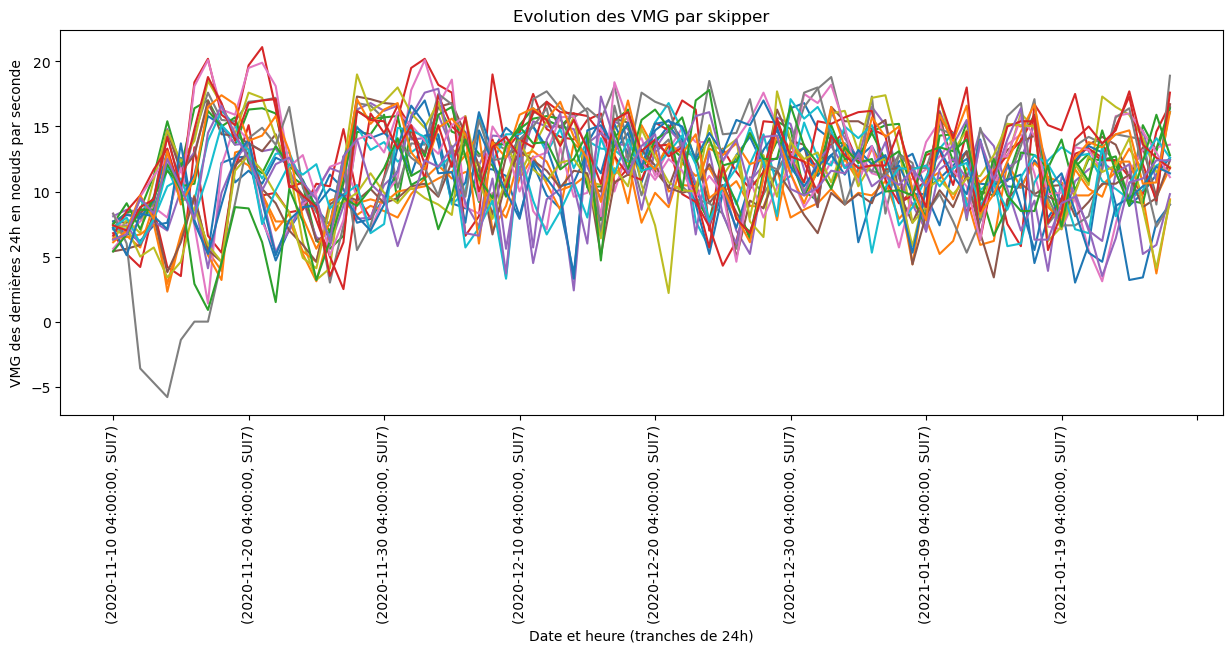

In [145]:
# sacrés sac de noeuds
data_rang_vmg.groupby('nationalite')['vmg_24h'].plot(rot=90, 
                                                     figsize = (15, 5), 
                                                     title = 'Evolution des VMG par skipper',
                                                     ylabel = 'VMG des dernières 24h en noeuds par seconde', 
                                                     xlabel = 'Date et heure (tranches de 24h)')[0]

<AxesSubplot:title={'center':'Evolution du rang des skippers'}, xlabel='Date et heure (tranches de 24h)', ylabel='Rang'>

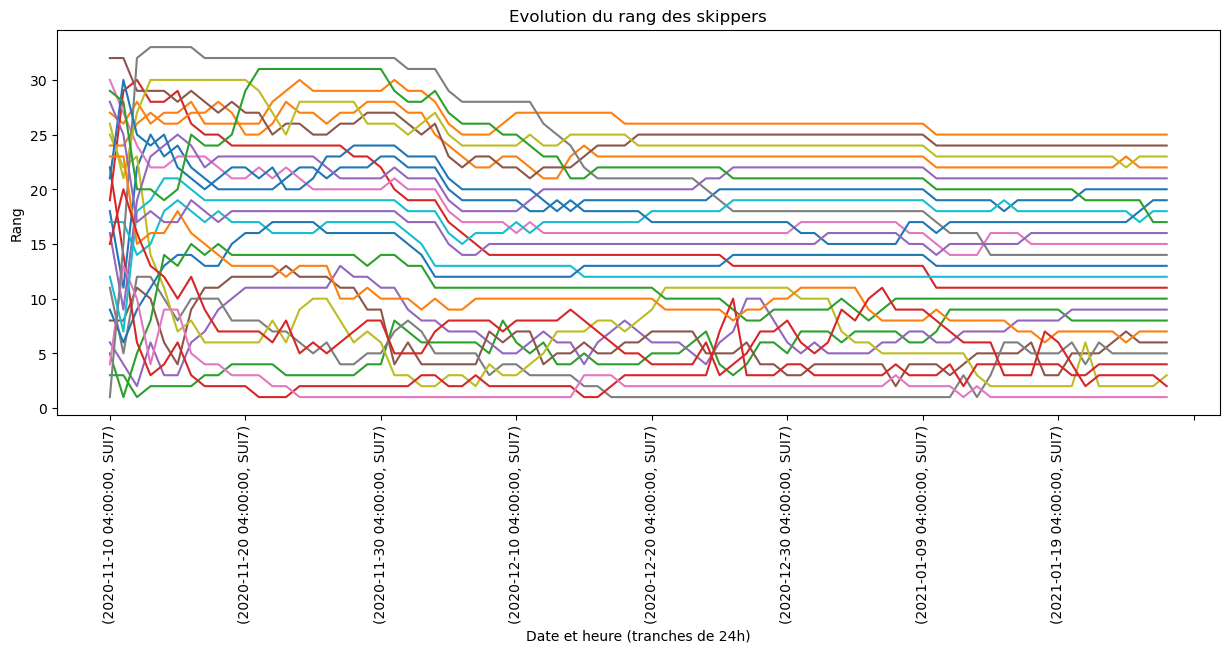

In [144]:
data_rang_vmg.groupby('nationalite')['rang'].plot(rot=90, 
                                                  figsize = (15, 5), 
                                                  title = 'Evolution du rang des skippers', 
                                                  xlabel = 'Date et heure (tranches de 24h)', 
                                                  ylabel = 'Rang')[0]

Les deux prochains graphes sont des divisions des 2 graphes ci-dessus par skipper, voir si c'est plus lisible !

array([<AxesSubplot:xlabel='Date et heure (tranches de 24h)', ylabel='VMG'>,
       <AxesSubplot:xlabel='Date et heure (tranches de 24h)', ylabel='VMG'>,
       <AxesSubplot:xlabel='Date et heure (tranches de 24h)', ylabel='VMG'>],
      dtype=object)

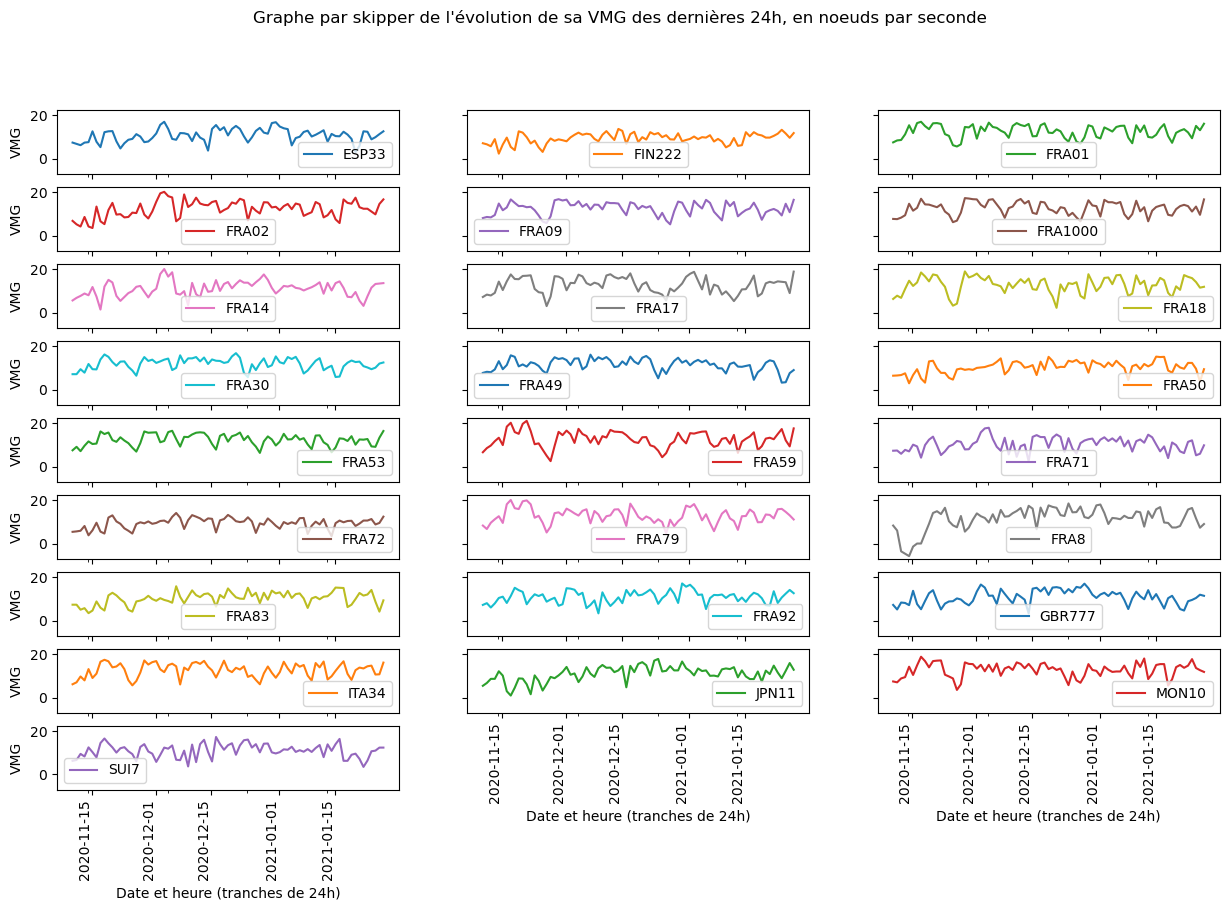

In [143]:
pd.pivot_table(data_rang_vmg.reset_index(),
               index='datetime_fichier', columns='nationalite', values='vmg_24h'
              ).plot(subplots=True, 
                     layout=(9,3), 
                     rot=90, 
                     sharey=True,
                     title = 'Graphe par skipper de l\'évolution de sa VMG des dernières 24h, en noeuds par seconde',
                     ylabel = 'VMG',
                     xlabel = 'Date et heure (tranches de 24h)',
                     figsize = (15, 10))[0]

array([<AxesSubplot:xlabel='Date et heure (tranches de 24h)', ylabel='Rang'>,
       <AxesSubplot:xlabel='Date et heure (tranches de 24h)', ylabel='Rang'>,
       <AxesSubplot:xlabel='Date et heure (tranches de 24h)', ylabel='Rang'>],
      dtype=object)

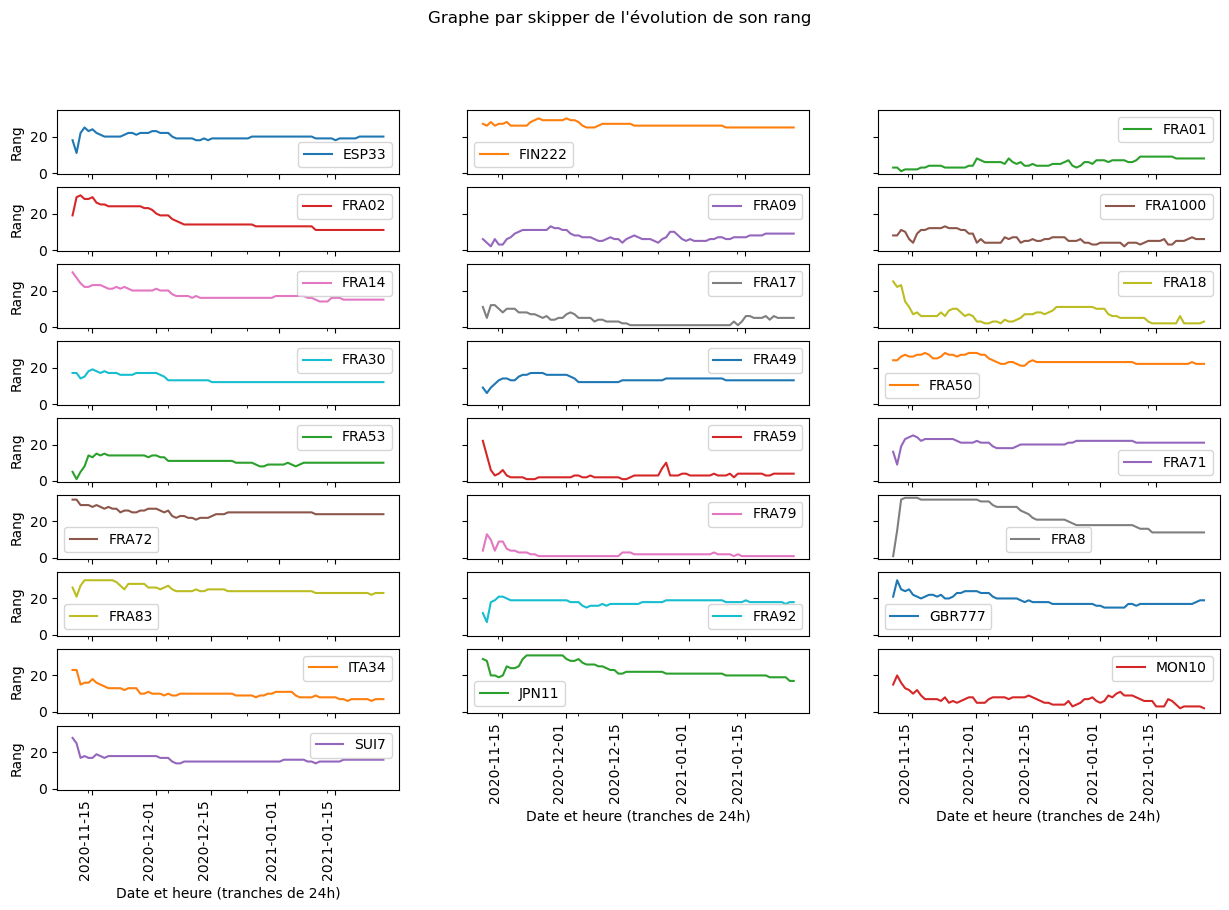

In [147]:
pd.pivot_table(data_rang_vmg.reset_index(),
               index='datetime_fichier', columns='nationalite', values='rang'
              ).plot(subplots=True, 
                     layout=(9,3), 
                     rot=90, 
                     sharey=True, 
                     title = 'Graphe par skipper de l\'évolution de son rang',
                     ylabel = 'Rang',
                     xlabel = 'Date et heure (tranches de 24h)',
                     figsize = (15, 10))[0]

array([<AxesSubplot:xlabel='Date et heure (tranches de 24h)', ylabel='VMG'>,
       <AxesSubplot:xlabel='Date et heure (tranches de 24h)', ylabel='VMG'>,
       <AxesSubplot:xlabel='Date et heure (tranches de 24h)', ylabel='VMG'>],
      dtype=object)

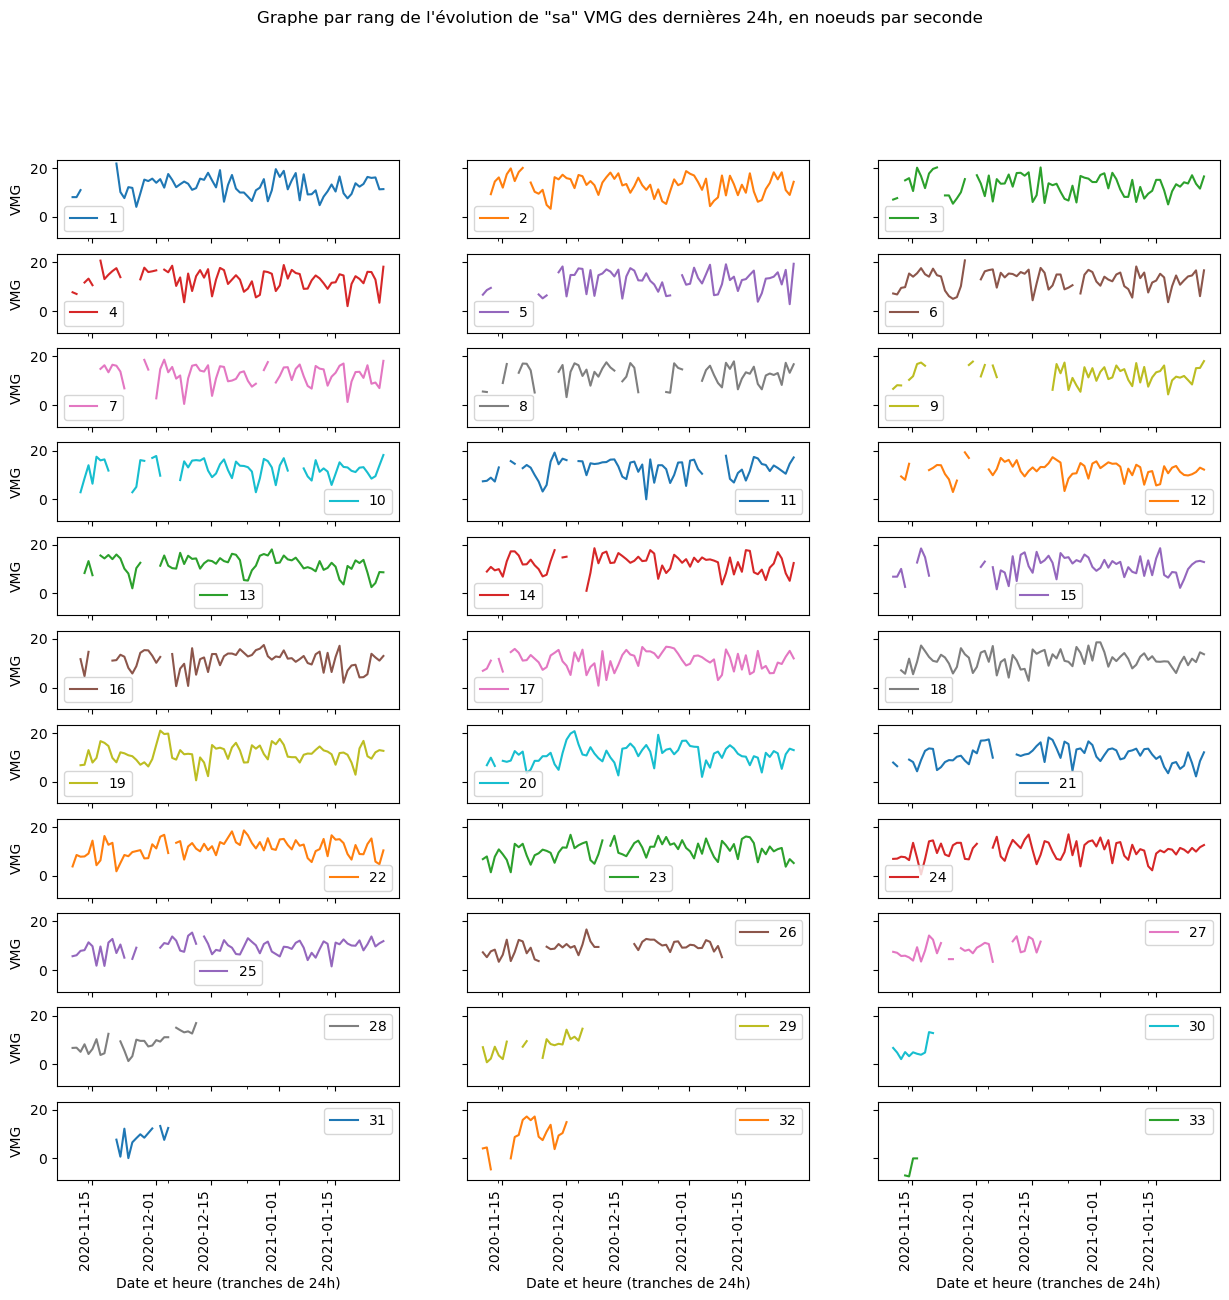

In [148]:
pd.pivot_table(data_rang_vmg.reset_index(),
               index='datetime_fichier', columns='rang', values='vmg_prec'
              ).plot(subplots=True, 
                     layout=(11,3), 
                     rot=90, 
                     sharey=True, 
                     title = 'Graphe par rang de l\'évolution de "sa" VMG des dernières 24h, en noeuds par seconde',
                     ylabel = 'VMG',
                     xlabel = 'Date et heure (tranches de 24h)',
                     figsize = (15, 15))[0]

Il n'y a pas de lien entre la vmg et le rang pour un classement donné. \
Peut-être, à la vue de ce dernier groupe de graphes, qu'il y a un lien entre rang VS la moyenne des vitesse jusqu'au moment du rang.

**Cependant**, le lien évident se trouve plutôt sur le tableau d'arrivée, plus on est rapide, mieux on est classé... \
Vérifions-le aussi.

In [64]:
# à partir du dernier tableau des arrivées
classement_vitesse = arrivee_bat[arrivee_bat['datetime_fichier'] == arrivee_bat['datetime_fichier'].max()]
classement_vitesse = classement_vitesse[classement_vitesse['rang'] != 'RET'].astype({'rang':'int'})
classement_vitesse= classement_vitesse.loc[:, ['rang', 'skipper', 'nationalite', 'vitesse_ortho', 'vitesse', 'Longueur', 'Largeur', 'Tirant d\'eau', 'Déplacement (poids)', 'Nombre de dérives', 'Hauteur mât', 'Voile quille', 'Surface de voiles au près', 'Surface de voiles au portant']]
classement_vitesse.head(3)

,rang,skipper,nationalite,vitesse_ortho,vitesse,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
17,1,Yannick Bestaven,FRA17,12.6,14.8,18.28,5.80,4.5,8.0,foils,29.0,acier mécano soudé,310.0,550.0
236,2,Charlie Dalin,FRA79,12.6,15.1,18.28,5.85,4.5,8.0,foils,29.0,acier,350.0,560.0
456,3,Louis Burton,FRA18,12.6,14.8,18.28,5.80,4.5,7.6,foils,28.0,acier,300.0,600.0


In [65]:
# coefficient de corrélation
pearsonr(classement_vitesse['rang'], classement_vitesse['vitesse'])

(-0.962379005879445, 1.6447026366995392e-14)

Là très clairement, plus un bateau est rapide plus son classement est numérique faible (proche de 1).

### III.1.b) Régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.

In [48]:
X = data_rang_vmg['vmg_24h'].to_numpy().reshape(-1,1)
y = data_rang_vmg['rang'].to_numpy()
reg = LinearRegression().fit(X, y)
reg.predict(X)
reg.score(X, y)

0.12208951292719317

Même en regardant le résultat sur les données d'entrainement la précision moyenne est faible. \
Si l'on voulait trouver une corrélation mieux vaudrait voir du côté du rang VS la moyenne des vitesses jusqu'au moment du rang.

---

## III.2) Impact de la présence d'un foil sur le classement et la vitesse des voiliers.

Une première approche est de comparer dans les 2 cas (présence d'un foil VS absence d'un foil), des statistiques sur le classement et la vitesse. Prenons la statistique naturelle, la moyenne, comme statistique.

In [106]:
# Sépare en 2 groupes les bateaux, avec et sans foils.
classement_vitesse.loc[classement_vitesse['Nombre de dérives'] != 'foils', 'Nombre de dérives'] = 'sans'
classement_vitesse[['rang', 'skipper', 'Nombre de dérives']].iloc[[0,3],:]

,rang,skipper,Nombre de dérives
17,1,Yannick Bestaven,foils
674,4,Jean Le Cam,sans


In [111]:
classement_vitesse.groupby('Nombre de dérives')['skipper'].count()

Nombre de dérives
foils    12
sans     13
Name: skipper, dtype: int64

C'est équilibré, ce qui est bien arrangeant, même si le nombre de skipper n'est pas grand.

In [104]:
classement_vitesse.groupby('Nombre de dérives')[['rang', 'vitesse']].mean()

,rang,vitesse
Nombre de dérives,,
foils,9.583333,13.933333
sans,16.153846,12.484615


On retrouve au passage le lien inverse entre rang et vitesse.
Vu comme ça on dirait qu'avoir un foil est gage de vitesse, ce que personnellement j'aurais cru avant de voir les données.

Comme on est sur des petits jeux de données de tailles différentes, et donc que les conditions de normalités sont difficiles à remplir, faisons un test de Mann-Whitney, qui est non paramétrique.

Etablissons un test avec un niveau de confiance à 95% nécessaire pour rejeter l'hypothèse nulle au profit de l'alternative. \
Dans le cas des rangs, l'hypothèse nulle est que les bateaux avec foil n'ont pas un rang plus petit que les sans foils. \
Dans le cas des vitesses, l'hypothèse nulle est que les bateaux avec foil n'ont pas une vitesse plus élevée que les sans foils.

In [128]:
mask_foil = classement_vitesse['Nombre de dérives'] == 'foils'
foils = classement_vitesse[mask_foil]
sans = classement_vitesse[~mask_foil]

mannwhitneyu(x = foils['rang'], y = sans['rang'], alternative='less', method = 'exact') # le test alternatif est que les rang des bateaux avec foil est plus petit que ceux sans

MannwhitneyuResult(statistic=37.0, pvalue=0.01283310578235871)

L'hypothèse nulle est rejetée ici, la pvalue est inférieure à 0.05 sur ce test unilatéral.

**Foils $\rightarrow$ meilleur classement !**

De même, regardons la vitesse...

In [129]:
mannwhitneyu(x = foils['vitesse'], y = sans['vitesse'], alternative='greater', method = 'exact') # le test alternatif est que la vitesse des bateaux avec foil est plus élevée que ceux sans

MannwhitneyuResult(statistic=126.0, pvalue=0.003989769820971867)

**Foils $\rightarrow$ meilleur vitesse !**

Quel soulagement, on trouve bien qu'un foil augmente la vitesse. Et le lien statistique est encore plus fort, normal c'est directement ce à quoi sert le foil !

---

## III.3) Visualisation de la course

### III.3.a) Cartes avec les routes d'un ou plusieurs voiliers

In [49]:
# convertit les colonnes de latitude et longitude
# en quelque chose d'exploitable pour plotly
def convertit_latlon(x):
    res = float(x[0]) + float(x[1])/60 + float(x[2])/3600
    if x[3] in ('S', 'W'):
        res *= -1
    return res

long = data_rang_vmg['longitude'].str.split(r"°|\.|'").apply(lambda x: convertit_latlon(x))
long.head(3)

datetime_fichier     nationalite
2020-11-10 04:00:00  FRA49         -8.850833
                     FRA50         -8.751667
                     FRA92         -8.658611
Name: longitude, dtype: float64

In [50]:
lat = data_rang_vmg['latitude'].str.split(r"°|\.|'").apply(lambda x: convertit_latlon(x))
lat.head(3)

datetime_fichier     nationalite
2020-11-10 04:00:00  FRA49          43.675278
                     FRA50          44.301389
                     FRA92          43.778056
Name: latitude, dtype: float64

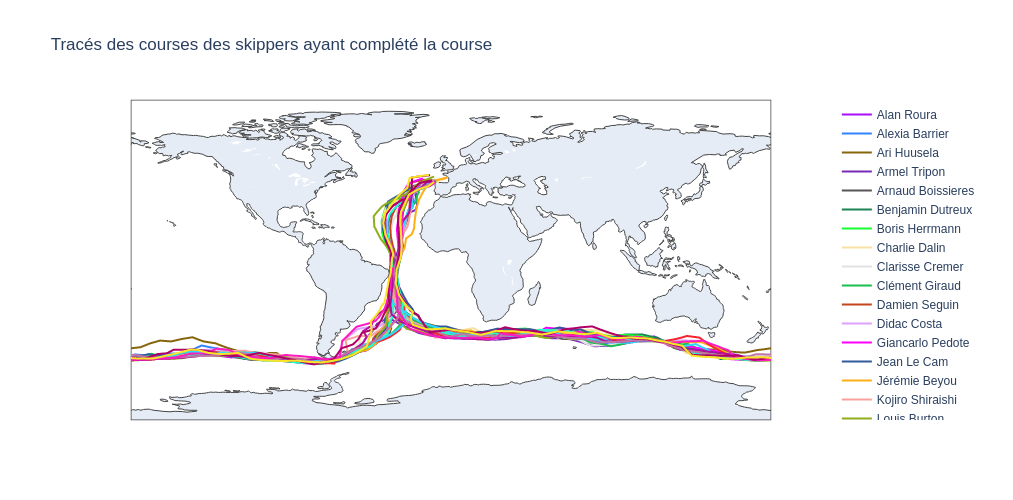

In [158]:
import plotly.express as px


fig = go.Figure()

for i, skipper in enumerate(np.unique(data_rang_vmg['skipper'])):
    fig.add_trace(go.Scattergeo(
        lon = long[data_rang_vmg['skipper'] == skipper],
        lat = lat[data_rang_vmg['skipper'] == skipper],
        hoverinfo = 'text',
        text = skipper,
        name = skipper,
        mode = 'lines',
        marker = dict(
            size = 1,
            color = px.colors.qualitative.Alphabet[i]
        )))

fig.update_layout(
    autosize=False,
    title = 'Tracés des courses des skippers ayant complété la course',
    width=1200,
    height=500)

fig.show()

Ci-dessus les tracés des trajets de chacun des participants ayant terminé la course. (Ne s'affiche possiblement pas dans le fichier visible sur github, mais il est là !)

### III.3.b) Visualisation de la distance parcourue par voilier

In [52]:
# à partir du dernier tableau des arrivées
classement = arrivee_bat[arrivee_bat['datetime_fichier'] == arrivee_bat['datetime_fichier'].max()]
classement = classement[classement['rang'] != 'RET']
classement.head(3)

,rang,nationalite,skipper,date_arrivee,temps_course,ecart_premier,ecart_precedent,vitesse_ortho,distance_ortho,pourcentage,...,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
17,1,FRA17,Yannick Bestaven,2021-01-28 04:19:46,80 days 03:44:46,NaT,NaT,12.6,24365.7,117.3 %,...,2015-03-12,18.28,5.80,4.5,8.0,foils,29.0,acier mécano soudé,310.0,550.0
236,2,FRA79,Charlie Dalin,2021-01-27 20:35:47,80 days 06:15:47,0 days 02:31:01,0 days 02:31:01,12.6,24365.7,119.6 %,...,2019-08-05,18.28,5.85,4.5,8.0,foils,29.0,acier,350.0,560.0
456,3,FRA18,Louis Burton,2021-01-28 00:45:12,80 days 10:25:12,0 days 06:40:26,0 days 04:09:25,12.6,24365.7,117.6 %,...,2015-06-09,18.28,5.80,4.5,7.6,foils,28.0,acier,300.0,600.0


In [53]:
print(f"La distance totale ortho de la course est de {np.unique(classement['distance_ortho'])[0]} milles.")

La distance totale ortho de la course est de 24365.7 milles.


Comparaison des distances sur le fond des participants, en fonction de leur rang


Text(0.5, 1.0, 'Comparaison des distances sur le fond des participants, en fonction de leur rang')

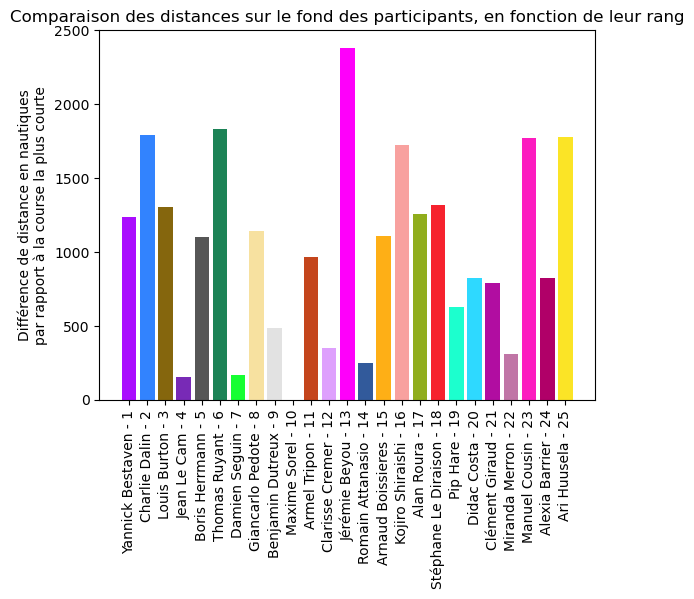

In [165]:
print(f"Comparaison des distances sur le fond des participants, en fonction de leur rang")
plt.bar(x = classement['rang'], 
        height = classement['distance'] - np.min(classement['distance']), 
        color = px.colors.qualitative.Alphabet, 
        tick_label = classement['skipper'] + ' - ' + classement['rang'],)[0]
plt.xticks(rotation=90)
plt.ylabel("Différence de distance en nautiques\npar rapport à la course la plus courte")
plt.title('Comparaison des distances sur le fond des participants, en fonction de leur rang')

**Le plus rapide n'est pas celui qui a fait la course la plus courte !** Par ailleurs, peut-être que des événements particuliers entrent en jeu (si un skipper a fait un détour pour de l'assistance en mer ou autre).

<AxesSubplot:title={'center':'Evolution du cumul de distance par skipper'}, xlabel='Date et heure (tranches de 24h)', ylabel='Distance cumulée en nautiques'>

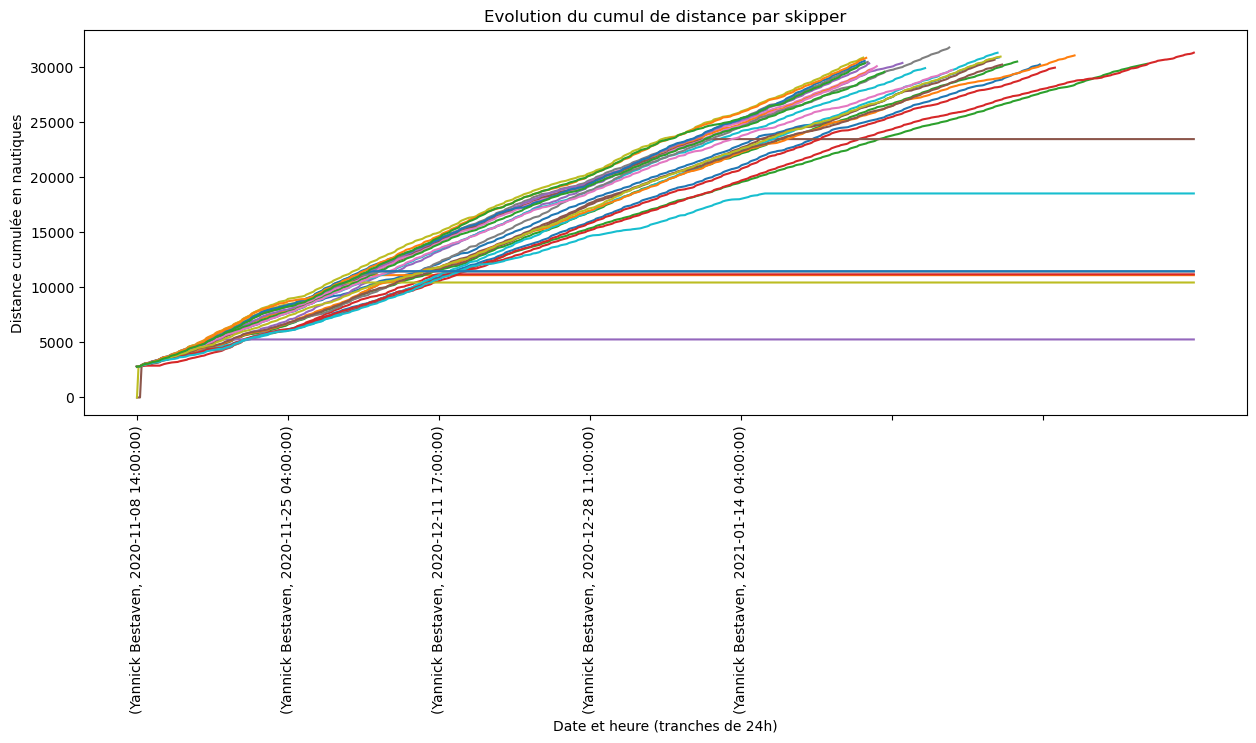

In [166]:
# Plus amusant est de représenter l'évolution du cumul de la distance par skipper
cumul_dist = course_bat.loc[:, ['skipper', 'datetime_fichier', 'dist_prec']].groupby(['skipper', 'datetime_fichier']).sum().groupby(level=0).cumsum()

cumul_dist.groupby('skipper')['dist_prec'].plot(rot=90, 
                                                figsize = (15, 5), 
                                                title = 'Evolution du cumul de distance par skipper',
                                                ylabel = 'Distance cumulée en nautiques', 
                                                xlabel = 'Date et heure (tranches de 24h)')[0]